# Modeling

- 1. [Introduction](#1.-Introduction)
- 2. [Imports](#2.-Imports)
- 3. [Loading the data](#3.-Loading-the-data)
- 4. [Sampling](#4.-Sampling)
    - 4.1 [Types of Sampling](#4.1-Types-of-Sampling)
    - 4.2 [Validation and Testing Set Distributions](#4.2-Validation-and-Testing-Set-Distributions)
- 5. [Model Selection](#5.-Model-Selection)
    - 5.1 [Baseline Models](#5.1-Baseline-Models)
    - 5.2 [Linear Models](#5.2-Linear-Models)
    - 5.3 [Tree Models](#5.3-Tree-Models)
    - 5.4 [Ensemble Methods](#5.4-Ensemble-Methods)
    
- 6. [Conclusion](#6.-Conclusion)


# 1. Introduction 

In this notebook, we perform select and evaluate models in an attempt to predict early readmission in diabetic patients. Previously, we've split our pre-processed data into training and test sets, which we will be using to train and evaluate our models respectively.

# 2. Imports

In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from functools import partial

from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from src.data import load_dataset as ld
from src.models.lace_index import LACEIndexClassifier
from src.models.evaluate import classification_report_from_models, train_models_over_samples, classification_report_over_samples, plot_roc_over_folds, \
plot_roc_over_models, kfold_samples, plot_feature_importance

pd.options.display.max_columns = 100

RANDOM_SEED = 0

# 3. Loading the data

In [2]:
training_data = ld.load_preprocessed_pickle('train.pkl')
testing_data = ld.load_preprocessed_pickle('test.pkl')
training_data_lace = ld.load_preprocessed_pickle('train_lace.pkl')

In [3]:
X_train, y_train = ld.split_dataset(training_data)
X_test, y_test = ld.split_dataset(testing_data)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55956, 80), (55956,), (14007, 80), (14007,))

In [5]:
X_train_lace, y_train_lace = ld.split_dataset(training_data_lace)
X_train_lace.shape, y_train_lace.shape

((55956, 20), (55956,))

# 4. Sampling

## 4.1 Types of Sampling

The original dataset had a rough 9:1 ratio of negative to positive observations and with such few observations in our minority class, our model may not learn a useful decision boundary. To combat this class imbalance in our training data, we experiment with different oversampling and undersampling techniques:
- **Random Oversampling**: Duplicate minority observations in our dataset by randomly sampling the minority class with replacement
- **SMOTE (Synthetic Minority Oversampling Technique)**: Synthesize novel minority observations that are similar to other minority observations in the feature space
- **Random Undersampling**: Randomly omit observations from the majority class

Other considerations:
- **SMOTE and Tomek Links**: SMOTE over-samples the minority class to create a more even representation between the two classes and Tomek Links, an undersampling technique, removes neighbors that are nearby in the feature space but belong to different classes, in order to increase the separation between the major and minor classes. imblearn's SMOTETomek implementation is very computationally intensive so it was not practical to experiment with this procedure for all models. Additionally, although increasing the separation between major and minor classes may improve generalization in theory, we observed in a reduced dimensional feature space that many positive observations were, in fact, near negative observations. Removing these pairs of neighbors may prevent our model from learning these nuances that differentiate these geometrically similar observations.

Here we initialize our sampling methods and the stratified k-fold helper we will be using during model evaluation:

In [6]:
smote = SMOTE(random_state=RANDOM_SEED, n_jobs=-1)
random_oversampler = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)
random_undersampler = RandomUnderSampler(random_state=RANDOM_SEED)

sampling_methods = [
    ('Initial data', None),
    ('SMOTE', smote),
    ('Random Oversampling', random_oversampler),
    ('Random Undersampling', random_undersampler)
]

In [7]:
skf = StratifiedKFold(n_splits=3, random_state=RANDOM_SEED, shuffle=True)

In [8]:
samples = kfold_samples(skf, X_train, y_train, sampling_methods)
samples_ut = kfold_samples(skf, X_train_ut, y_train_ut, sampling_methods)

In [9]:
def roc_plots(estimator, sampling_methods=sampling_methods):
    _, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes_iter = iter(axes.flatten())
    for name, sampler in sampling_methods:
        ax = next(axes_iter)
        plot_roc_over_folds(X_train, y_train, skf, estimator, sampler, ax=ax)
        ax.set_title(ax.get_title() + f' (sampling={name})')
    plt.tight_layout()
    
def plot_model_roc(model_sample_pairs):
    _, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes_iter = iter(axes.flatten())
    step = 3
    for i in range(0, len(model_sample_pairs), step):
        ax = next(axes_iter)
        plot_roc_over_models(model_sample_pairs[i:i+step], ax=ax)
    
    plt.tight_layout()
    
def plot_model_feature_importance(model_sample_pairs, figsize=(25, 20)):
    _, axes = plt.subplots(4, 3, figsize=figsize)
    axes_iter = iter(axes.flatten())
    for i, (estimator, X_train, _, _, _) in enumerate(model_sample_pairs):
        ax = next(axes_iter)
        plot_feature_importance(estimator.feature_importances_, X_train.columns, max_num=10, title=f'{estimator.__sample__} (fold={i%3})', ax=ax)
    
    plt.suptitle(f'Feature Importances for {estimator.__class__.__name__}', y=1.025, fontsize='x-large', fontweight='bold')
    plt.tight_layout() 

## 4.2 Validation and Testing Set Distributions
An assumption that we're making about our validation set is that its observations come from the same distribution as the test set. If they come from different distributions, our validation set is useless and we don't expect our models to learn patterns that will generalize well to unseen data.

In this offline learning project, we have created our own test set. Having access to both the validation and test set, we can manually verify that they are drawn from approximately distributions:

- For each validation set that we constructed through stratified sampling, we construct a new dataset composed of the validation set, $V$, and a random stratified sample of the test set of size equal to that of the validation set, $T$.
- We set the target variables of the observations in $V$ to 1 and the target variables of the observations in $T$ to 0.
- We then train a classifier to differentiate between observations in $V$ and $T$ and generate a cross-validated accuracy score. If the score is approximately 50%, then our classifier was not able to sufficiently distinguish observations from $T$ and $V$, and, as a result, we can be more confident that they are drawn from approximately identical distributions.

In [10]:
for i, (_, validation_indices) in enumerate(StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True).split(X_train, y_train)):
    xv = X_train.iloc[validation_indices]
    yv = pd.Series(np.ones((len(xv),)))
    
    xt, _, yt, _ = train_test_split(X_test, y_test, stratify=y_test, test_size=1-len(xv)/len(X_test), random_state=RANDOM_SEED)
    yt = pd.Series(np.zeros((len(xt,))))
    
    X = pd.concat([xv, xt], axis=0).reset_index(drop=True)
    y = pd.concat([yv, yt], axis=0).reset_index(drop=True)
    clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
    
    accuracies = []
    for (_, (ti, vi)) in enumerate(StratifiedKFold(n_splits=3, random_state=RANDOM_SEED, shuffle=True).split(X, y)):
        clf.fit(X.iloc[ti], y.iloc[ti].to_numpy().flatten())
        y_pred = clf.predict(X.iloc[vi])
        accuracies.append(accuracy_score(y.iloc[vi], y_pred))

    print(f'Fold {i}: Mean CV accuracy={sum(accuracies) / len(accuracies)}')

Fold 0: Mean CV accuracy=0.4945498180221179
Fold 1: Mean CV accuracy=0.5077074484070219
Fold 2: Mean CV accuracy=0.5052499688879641
Fold 3: Mean CV accuracy=0.49381185500916946
Fold 4: Mean CV accuracy=0.5019885351998399


The mean average cross-validated accuracy oscillates around 0.5 across folds. Therefore, we can trust that the means by which we generate our validation set is representative of the testing set, which we'll eventually use to assess our model's final performance.

# 5. Model Selection

Our learning task is to identify early readmission patient encounters. We experiment with a collection of candidate models and sampling methods to:
1. Determine the sampling method that performs best during validation
2. Identify a subset of candidate models that demonstrates promising results in order to reduce the scope of our hyperparameter tuning
3. Begin to understand the subset of features that is most critical for learning

Our evaluation of these candidate models are based on its utility in practice. A false negative (a patient who fails to be classified as someone who will likely re-admit within 30 days) has much more dire health and financial implications than those of a false positive. With that in mind, we primarily focus on metrics like recall, which tell us how accurately our learner classifies the positive class.

We will evaluate each sampling method-model pair using $K$-fold cross-validation, mean-averaging the following metrics over $K$ folds:
 - **Precision**: The number of patients that we correctly predicted would readmit early per the number of all patients that we predicted would readmit early
 - **Recall**: The number of patients that we correctly predicted would readmit early per the number of all patients that readmitted early
 
 - **f2 Score**: The harmonic mean of both precision and recall. $\beta = 2$, meaning we place more emphasis on minimizing the presence of false negatives
 - **ROC AUC Score**: The probability that the model ranks a random positive observation more highly than a random negative observation.


| Average Precision Score | Average Recall Score | Average f2-score ($\beta = 2$)| Average ROC AUC |
| ----------------- | --------------------- | ----------------------------- | --------------- |
$\frac{1}{K}\sum_{i=0}^{K}\frac{TP}{TP + FP}$ | $\frac{1}{K}\sum_{i=0}^{K} \frac{TP}{TP + FN}$ | $\frac{1}{K}\sum_{i=0}^{K} \frac{(1 + \beta^2) PR}{\beta^2 P + R}$ | $\frac{1}{K}\sum_{i=0}^{K} \int_{0}^{1} ROC$



## 5.1 Baseline Models

### 5.1.1 Dummy Classifier

We first train a dummy classifier, based on a basic heuristic of using the most frequently occurring label as a prediction.

In [11]:
dummy = DummyClassifier(strategy='most_frequent')
dummy_models = train_models_over_samples(dummy, samples)

In [12]:
classification_report_from_models(dummy_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.0,0.0,0.0,0.5,3347.333333,33956.666667,0.089731
Random Oversampling,0.0,0.0,0.0,0.5,33956.666667,33956.666667,0.500000
Random Undersampling,0.0,0.0,0.0,0.5,3347.333333,3347.333333,0.500000
SMOTE,0.0,0.0,0.0,0.5,33956.666667,33956.666667,0.500000


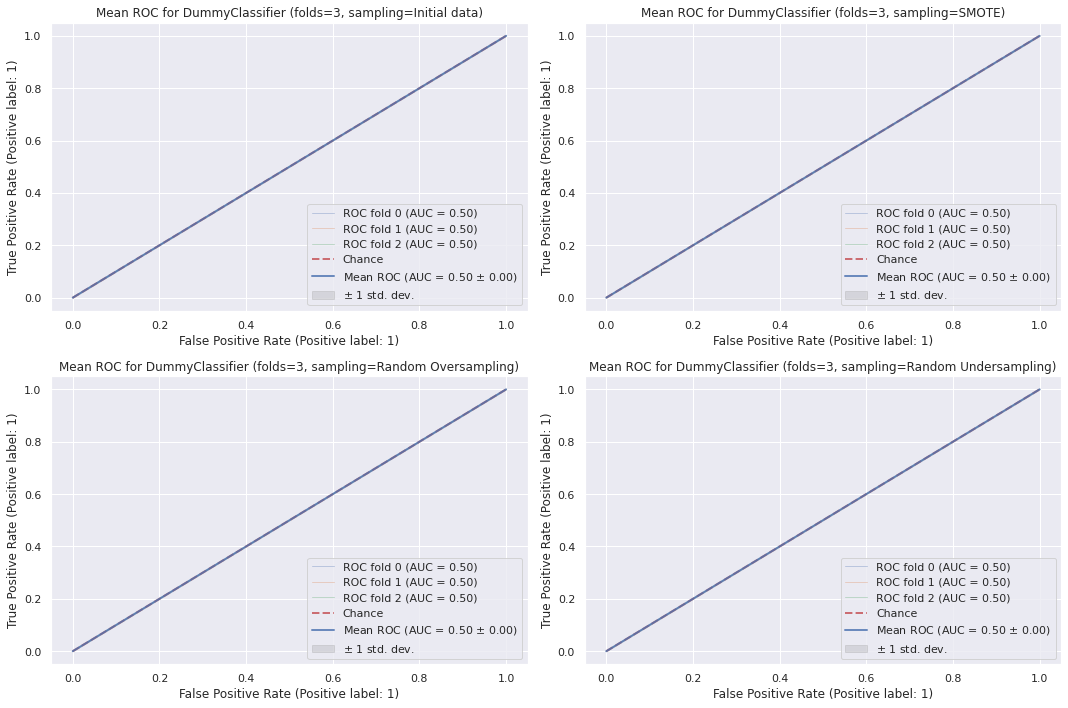

In [13]:
plot_model_roc(dummy_models)

In [14]:
del dummy_models; del dummy;

### 5.1.2 LACE Index



In [15]:
lace = LACEIndexClassifier()

lace_sampling_methods = [
    ('Initial data', None),
    ('SMOTE', SMOTENC(random_state=RANDOM_SEED, categorical_features=np.arange(2, len(X_train_lace.columns)))),
    ('Random Oversampling', random_oversampler),
    ('Random Undersampling', random_undersampler)
]

lace_samples = kfold_samples(skf, X_train_lace, y_train_lace, lace_sampling_methods)
lace_models = train_models_over_samples(lace, lace_samples)

In [16]:
classification_report_from_models(lace_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.102237,0.495921,0.280149,0.546603,3347.333333,33956.666667,0.089731
Random Oversampling,0.102237,0.495921,0.280149,0.546603,33956.666667,33956.666667,0.500000
Random Undersampling,0.102237,0.495921,0.280149,0.546603,3347.333333,3347.333333,0.500000
SMOTE,0.102237,0.495921,0.280149,0.546603,33956.666667,33956.666667,0.500000


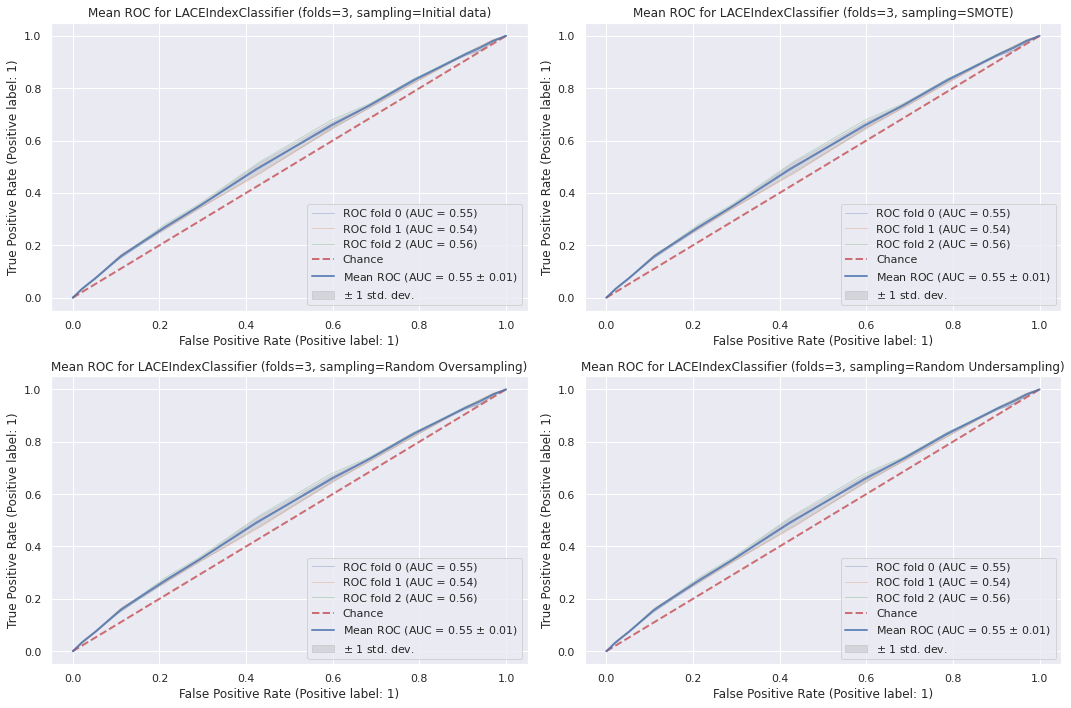

In [17]:
plot_model_roc(lace_models)

In [18]:
del lace_models; del lace_samples; del lace;

## 5.2 Linear Models
### 5.2.1 Logistic Regression

In [19]:
logreg = LogisticRegression(solver='lbfgs', random_state=RANDOM_SEED, max_iter=1000, n_jobs=-1)
logreg_models = train_models_over_samples(logreg, samples)

In [20]:
classification_report_from_models(logreg_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.000000,0.000000,0.000000,0.637883,3347.333333,33956.666667,0.089731
Random Oversampling,0.132564,0.554871,0.338908,0.638735,33956.666667,33956.666667,0.500000
Random Undersampling,0.131502,0.568016,0.341348,0.635734,3347.333333,3347.333333,0.500000
SMOTE,0.099661,0.110933,0.108456,0.522129,33956.666667,33956.666667,0.500000


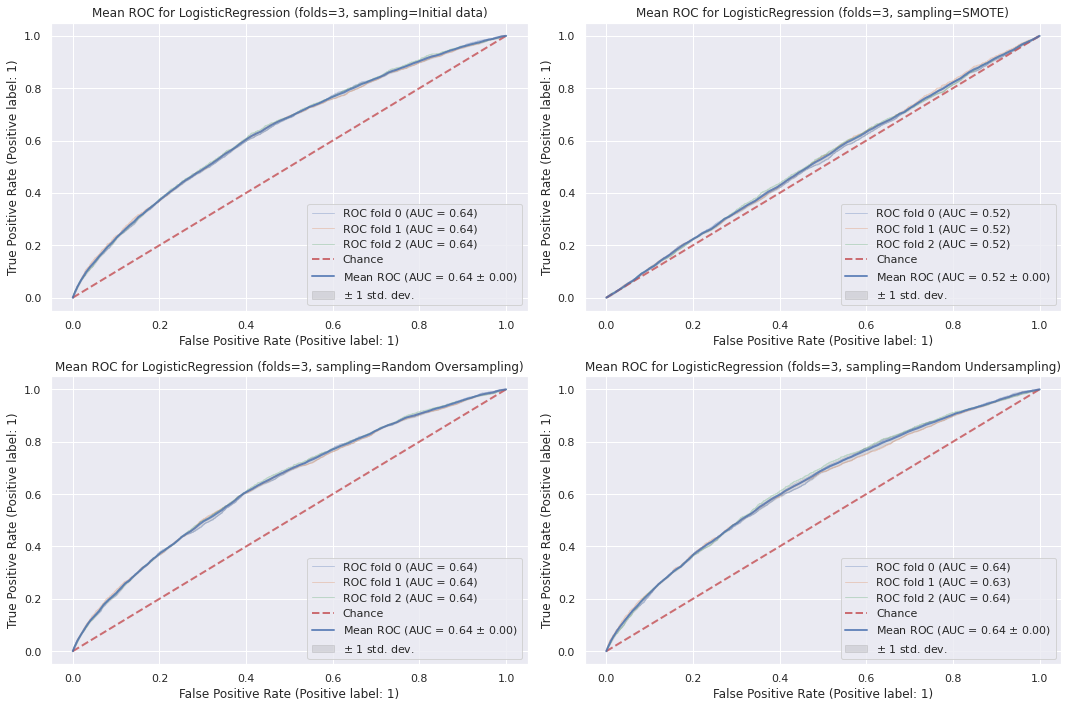

In [21]:
plot_model_roc(logreg_models)

In [22]:
del logreg_models; del logreg;

## 5.3 Tree Models

### 5.3.1 Decision Tree

In [23]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)
tree_models = train_models_over_samples(tree, samples)

In [24]:
classification_report_from_models(tree_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.115718,0.139016,0.133619,0.517108,3347.333333,33956.666667,0.089731
Random Oversampling,0.110484,0.125871,0.122454,0.512980,33956.666667,33956.666667,0.500000
Random Undersampling,0.102231,0.538136,0.290444,0.536173,3347.333333,3347.333333,0.500000
SMOTE,0.104095,0.150369,0.138080,0.511417,33956.666667,33956.666667,0.500000


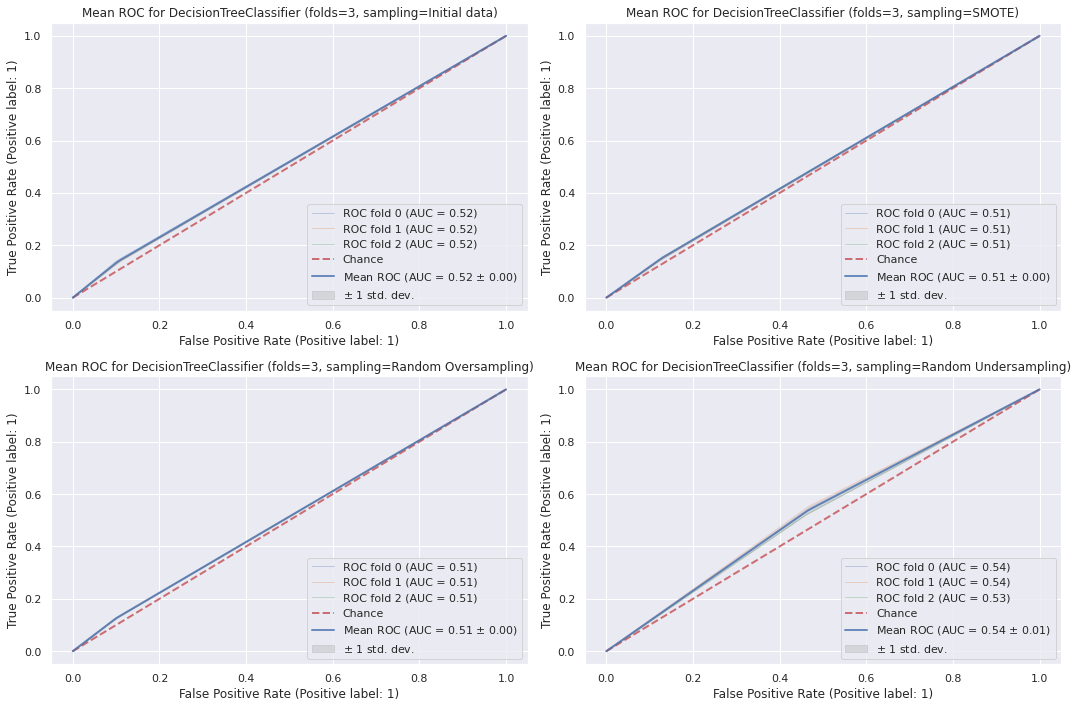

In [25]:
plot_model_roc(tree_models)

In [26]:
del tree_models; del tree;

## 5.4 Ensemble Methods

### 5.4.1 Random Forest Classifier

In [27]:
forest = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
forest_models = train_models_over_samples(forest, samples_ut)

In [28]:
classification_report_from_models(forest_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.333333,0.000598,0.000747,0.613319,3347.333333,33956.666667,0.089731
Random Oversampling,0.466387,0.005776,0.007196,0.618196,33956.666667,33956.666667,0.500000
Random Undersampling,0.127079,0.562437,0.333742,0.626966,3347.333333,3347.333333,0.500000
SMOTE,0.115732,0.009361,0.011469,0.580022,33956.666667,33956.666667,0.500000


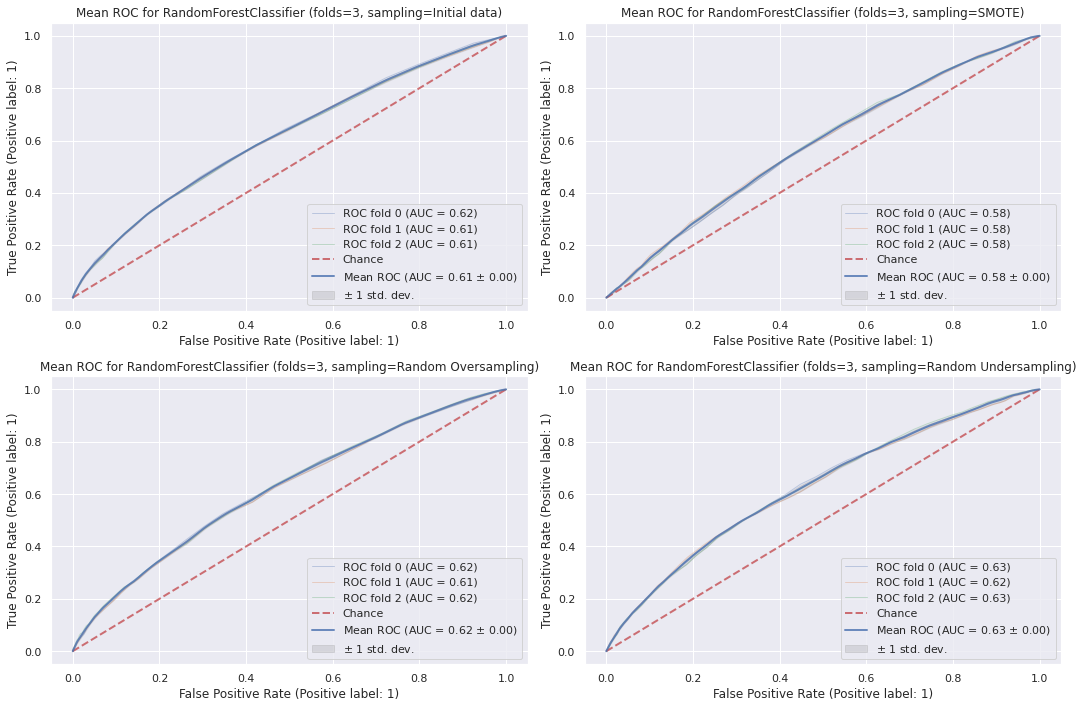

In [29]:
plot_model_roc(forest_models)

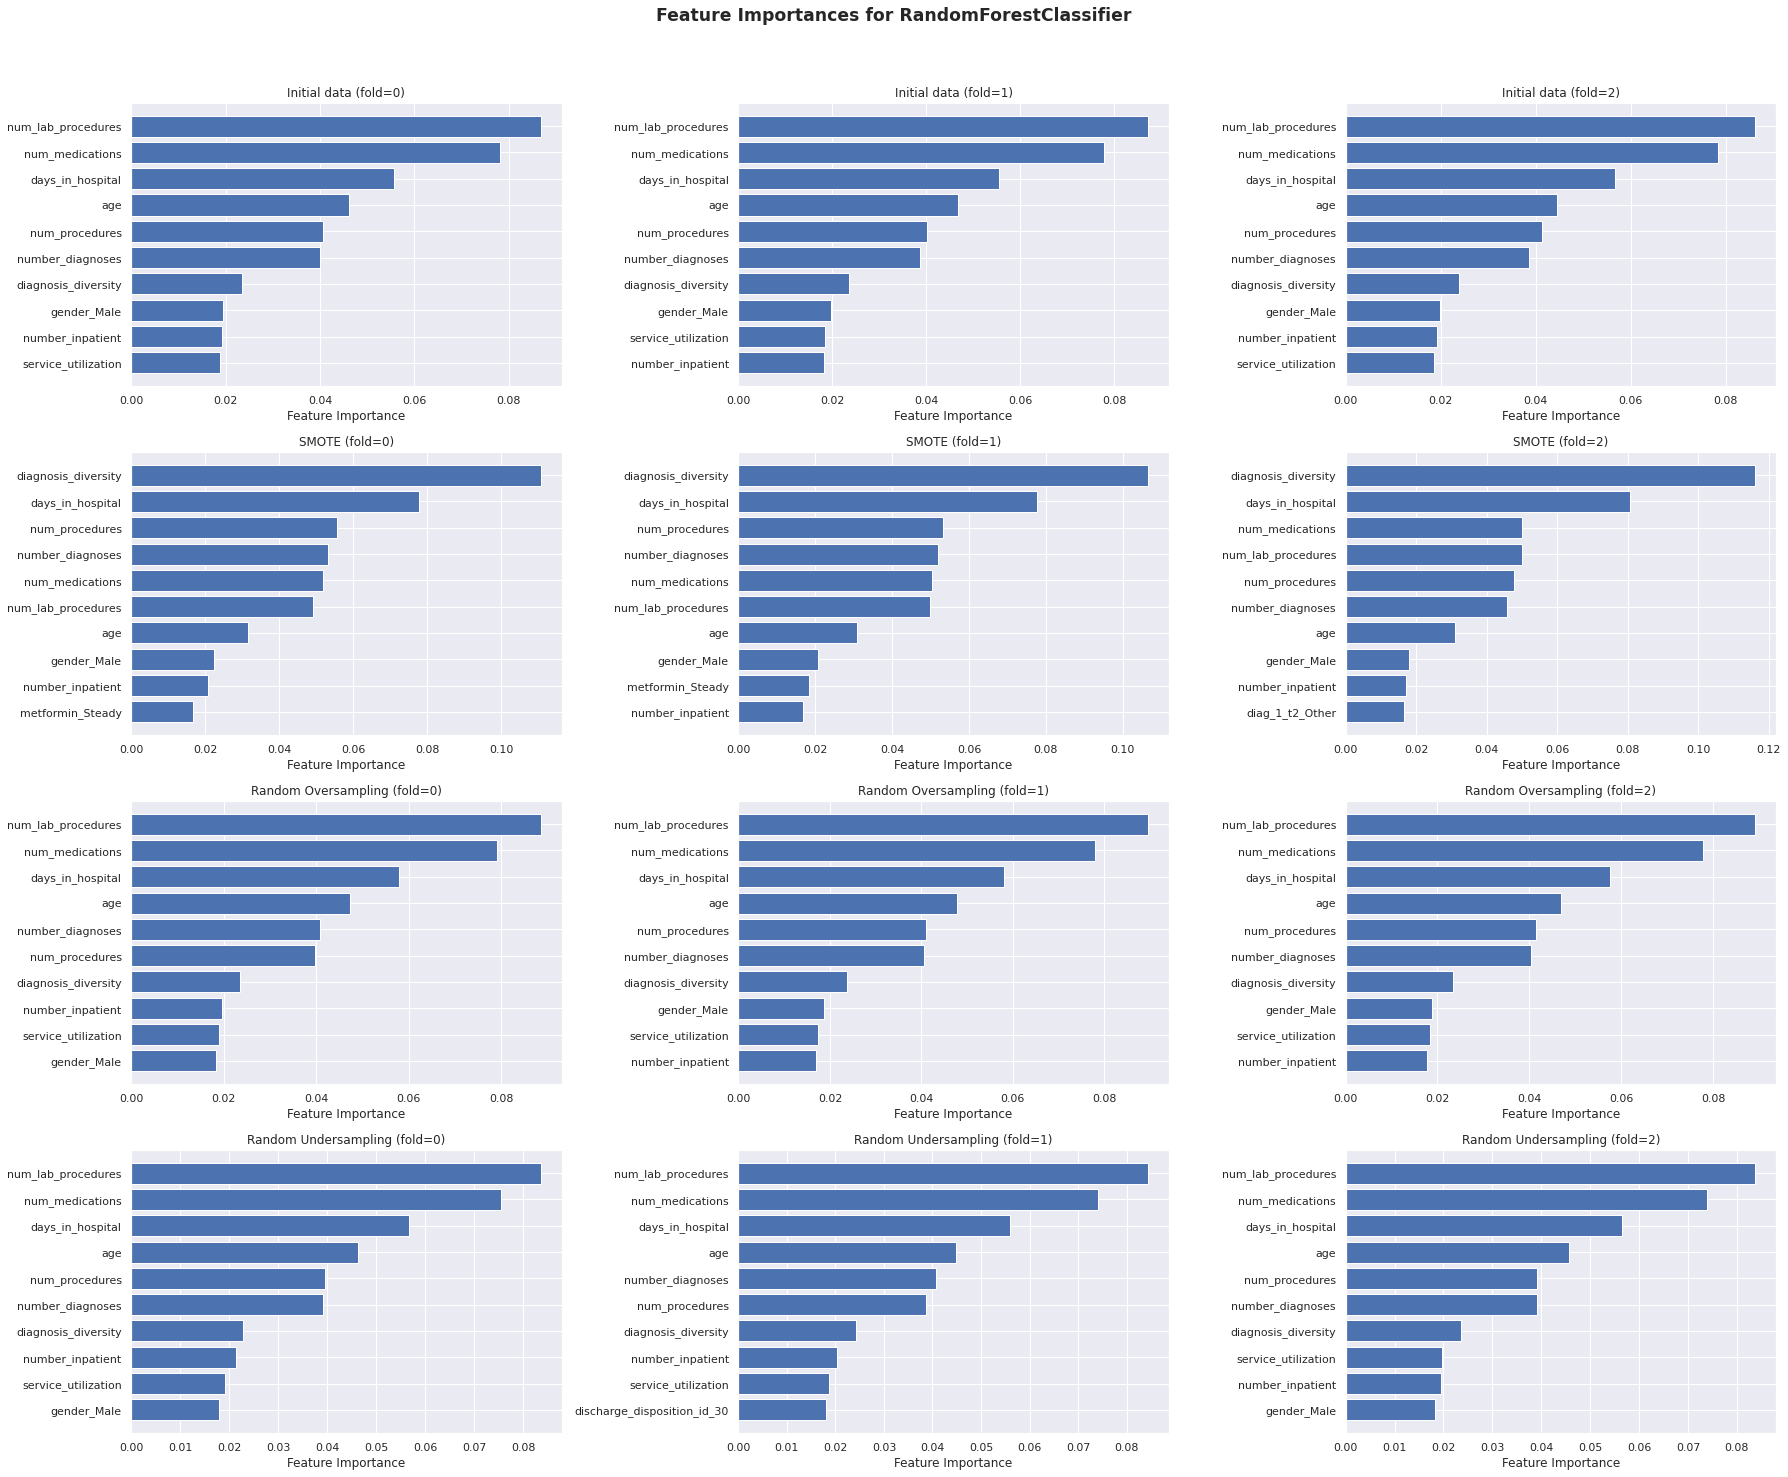

In [30]:
plot_model_feature_importance(forest_models)

In [31]:
del forest_models; del forest;

### 5.4.2 Gradient Boosting Classifier

In [32]:
gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
gb_models = train_models_over_samples(gb, samples)

In [33]:
classification_report_from_models(gb_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.374074,0.002789,0.003478,0.646952,3347.333333,33956.666667,0.089731
Random Oversampling,0.139169,0.541726,0.343106,0.646317,33956.666667,33956.666667,0.500000
Random Undersampling,0.134015,0.556262,0.341152,0.642667,3347.333333,3347.333333,0.500000
SMOTE,0.140719,0.039434,0.046050,0.562541,33956.666667,33956.666667,0.500000


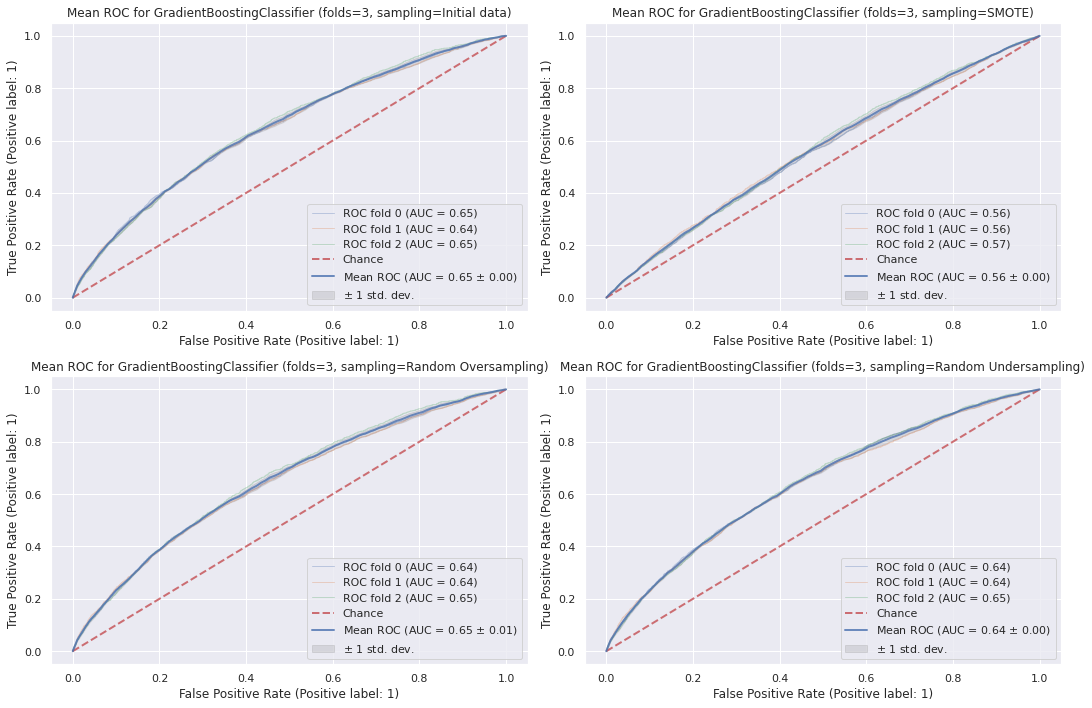

In [34]:
plot_model_roc(gb_models)

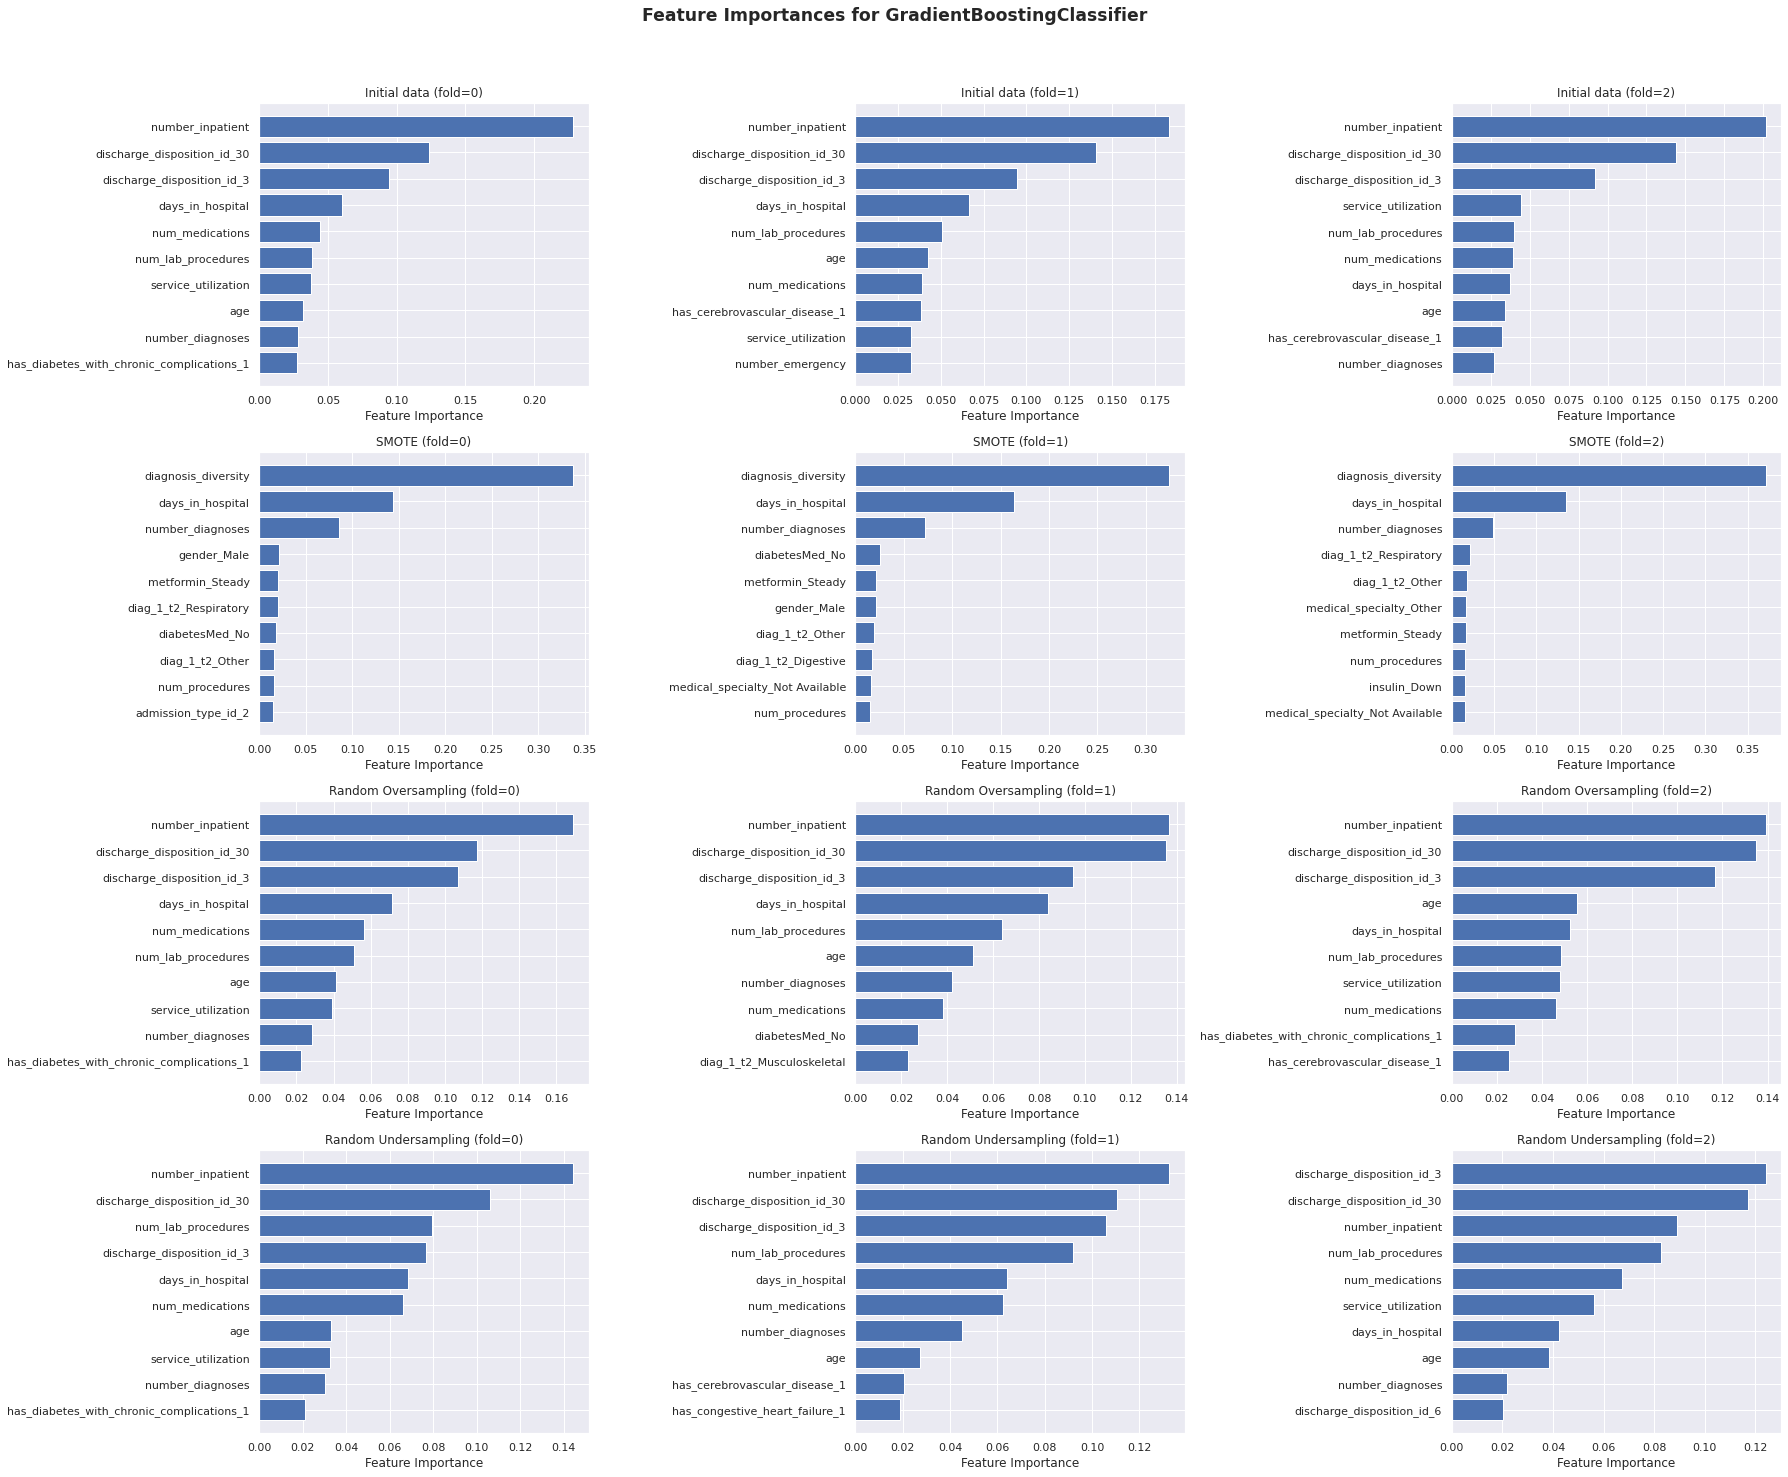

In [35]:
plot_model_feature_importance(gb_models)

In [36]:
del gb_models; del gb

### 5.4.3 Light GBM Classifier

In [37]:
lgbm = LGBMClassifier(random_state=RANDOM_SEED)
lgbm_models = train_models_over_samples(lgbm, samples)

In [38]:
classification_report_from_models(lgbm_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.194444,0.001593,0.001988,0.637566,3347.333333,33956.666667,0.089731
Random Oversampling,0.143213,0.457478,0.317815,0.630941,33956.666667,33956.666667,0.500000
Random Undersampling,0.130100,0.566417,0.338993,0.633050,3347.333333,3347.333333,0.500000
SMOTE,0.144259,0.003785,0.004699,0.603768,33956.666667,33956.666667,0.500000


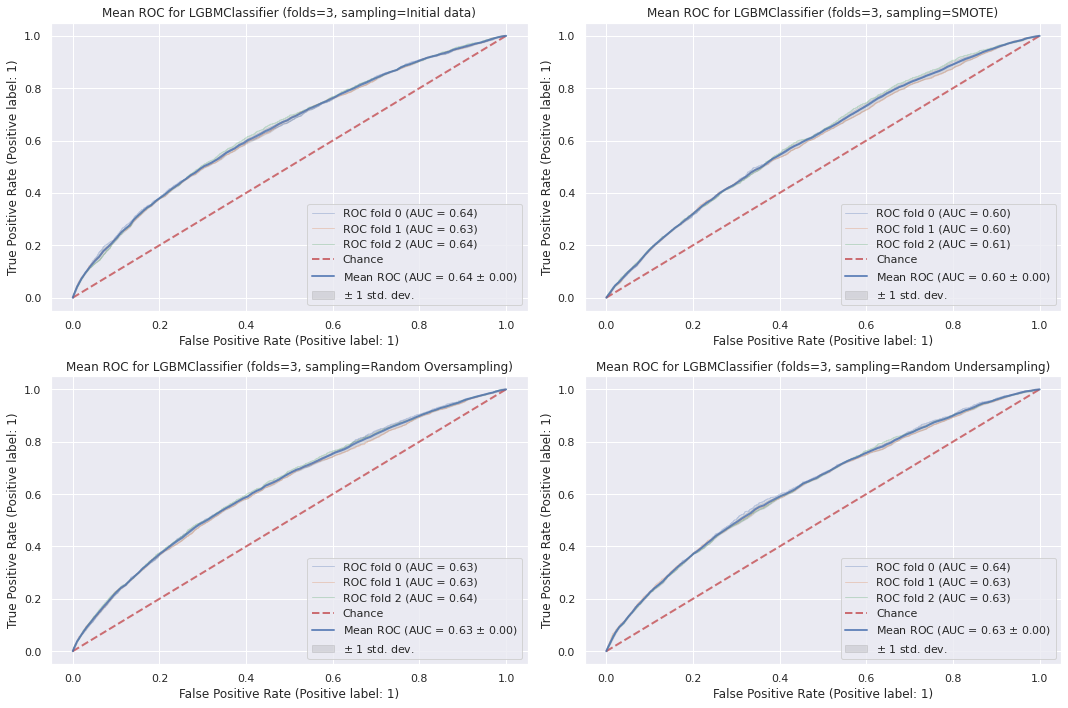

In [39]:
plot_model_roc(lgbm_models)

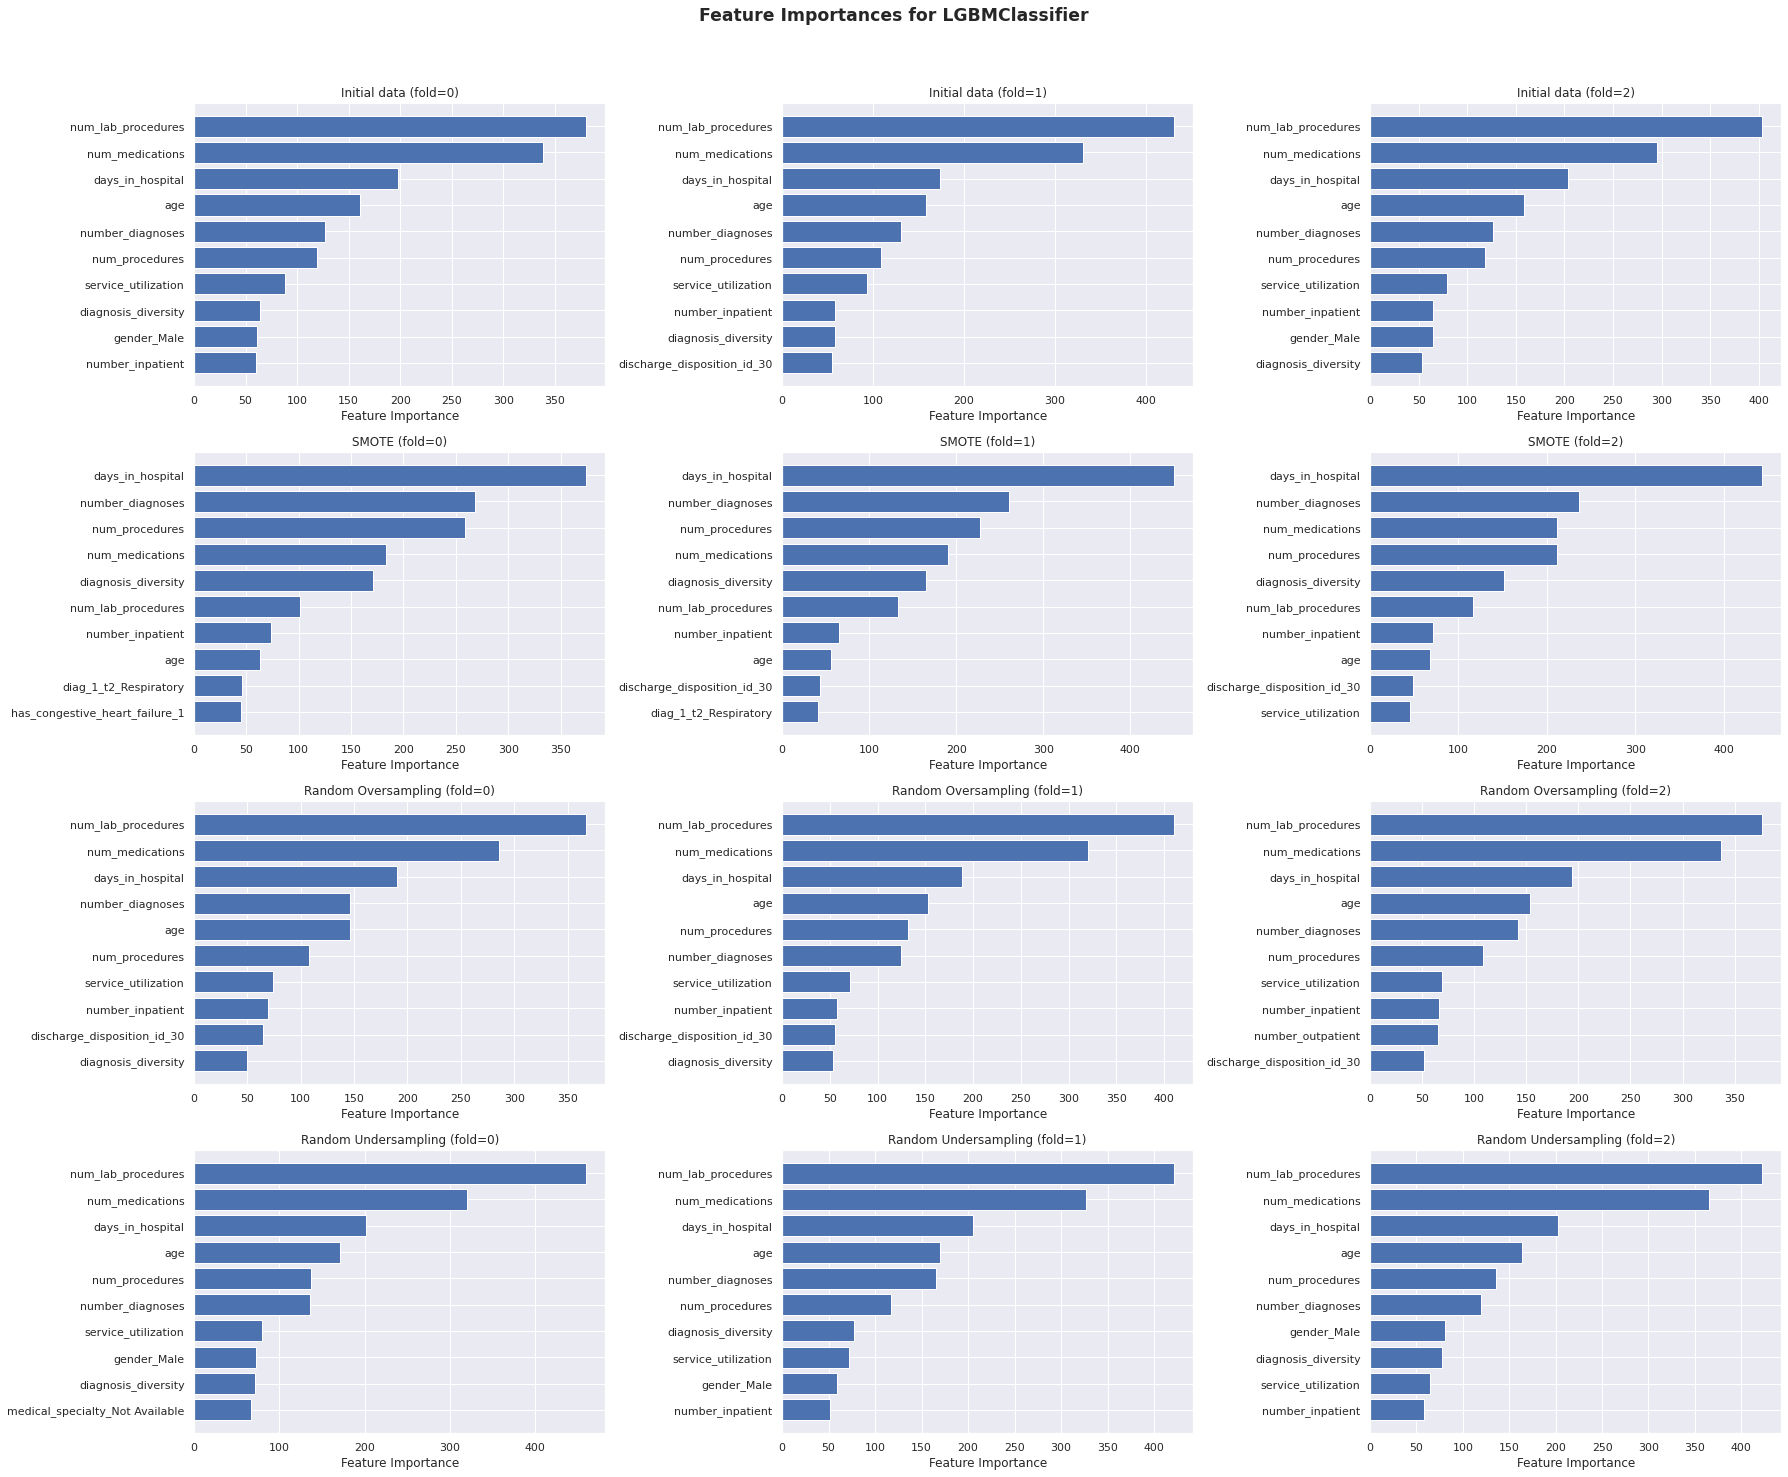

In [40]:
plot_model_feature_importance(lgbm_models)

In [41]:
del lgbm_models; del lgbm;

### 5.4.4 XGBoost

In [42]:
xgb = XGBClassifier(random_state=RANDOM_SEED, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_models = train_models_over_samples(xgb, samples)

In [43]:
classification_report_from_models(xgb_models)

,Average Precision,Average Recall,Average f2-score,Average ROC AUC,Average # of Positive Obs.,Average # of Negative Obs.,Average Proportion of Positive Obs.
Initial data,0.280174,0.014539,0.017941,0.613569,3347.333333,33956.666667,0.089731
Random Oversampling,0.138691,0.331606,0.259350,0.596199,33956.666667,33956.666667,0.500000
Random Undersampling,0.120501,0.567813,0.325873,0.610800,3347.333333,3347.333333,0.500000
SMOTE,0.242165,0.018124,0.022231,0.593569,33956.666667,33956.666667,0.500000


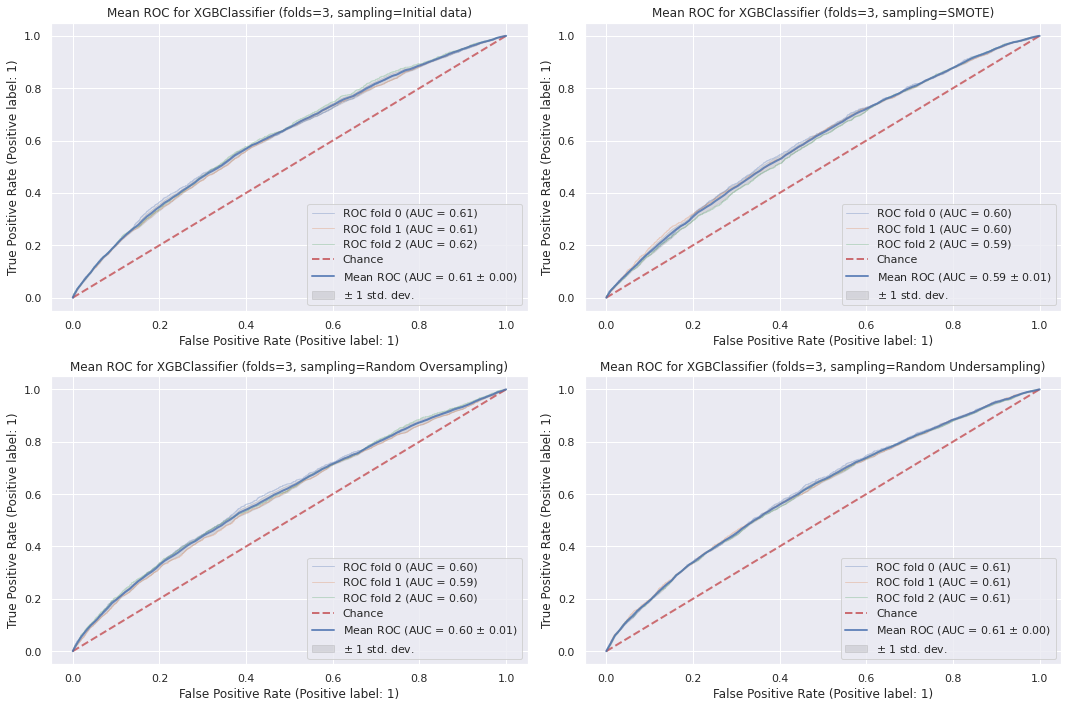

In [44]:
plot_model_roc(xgb_models)

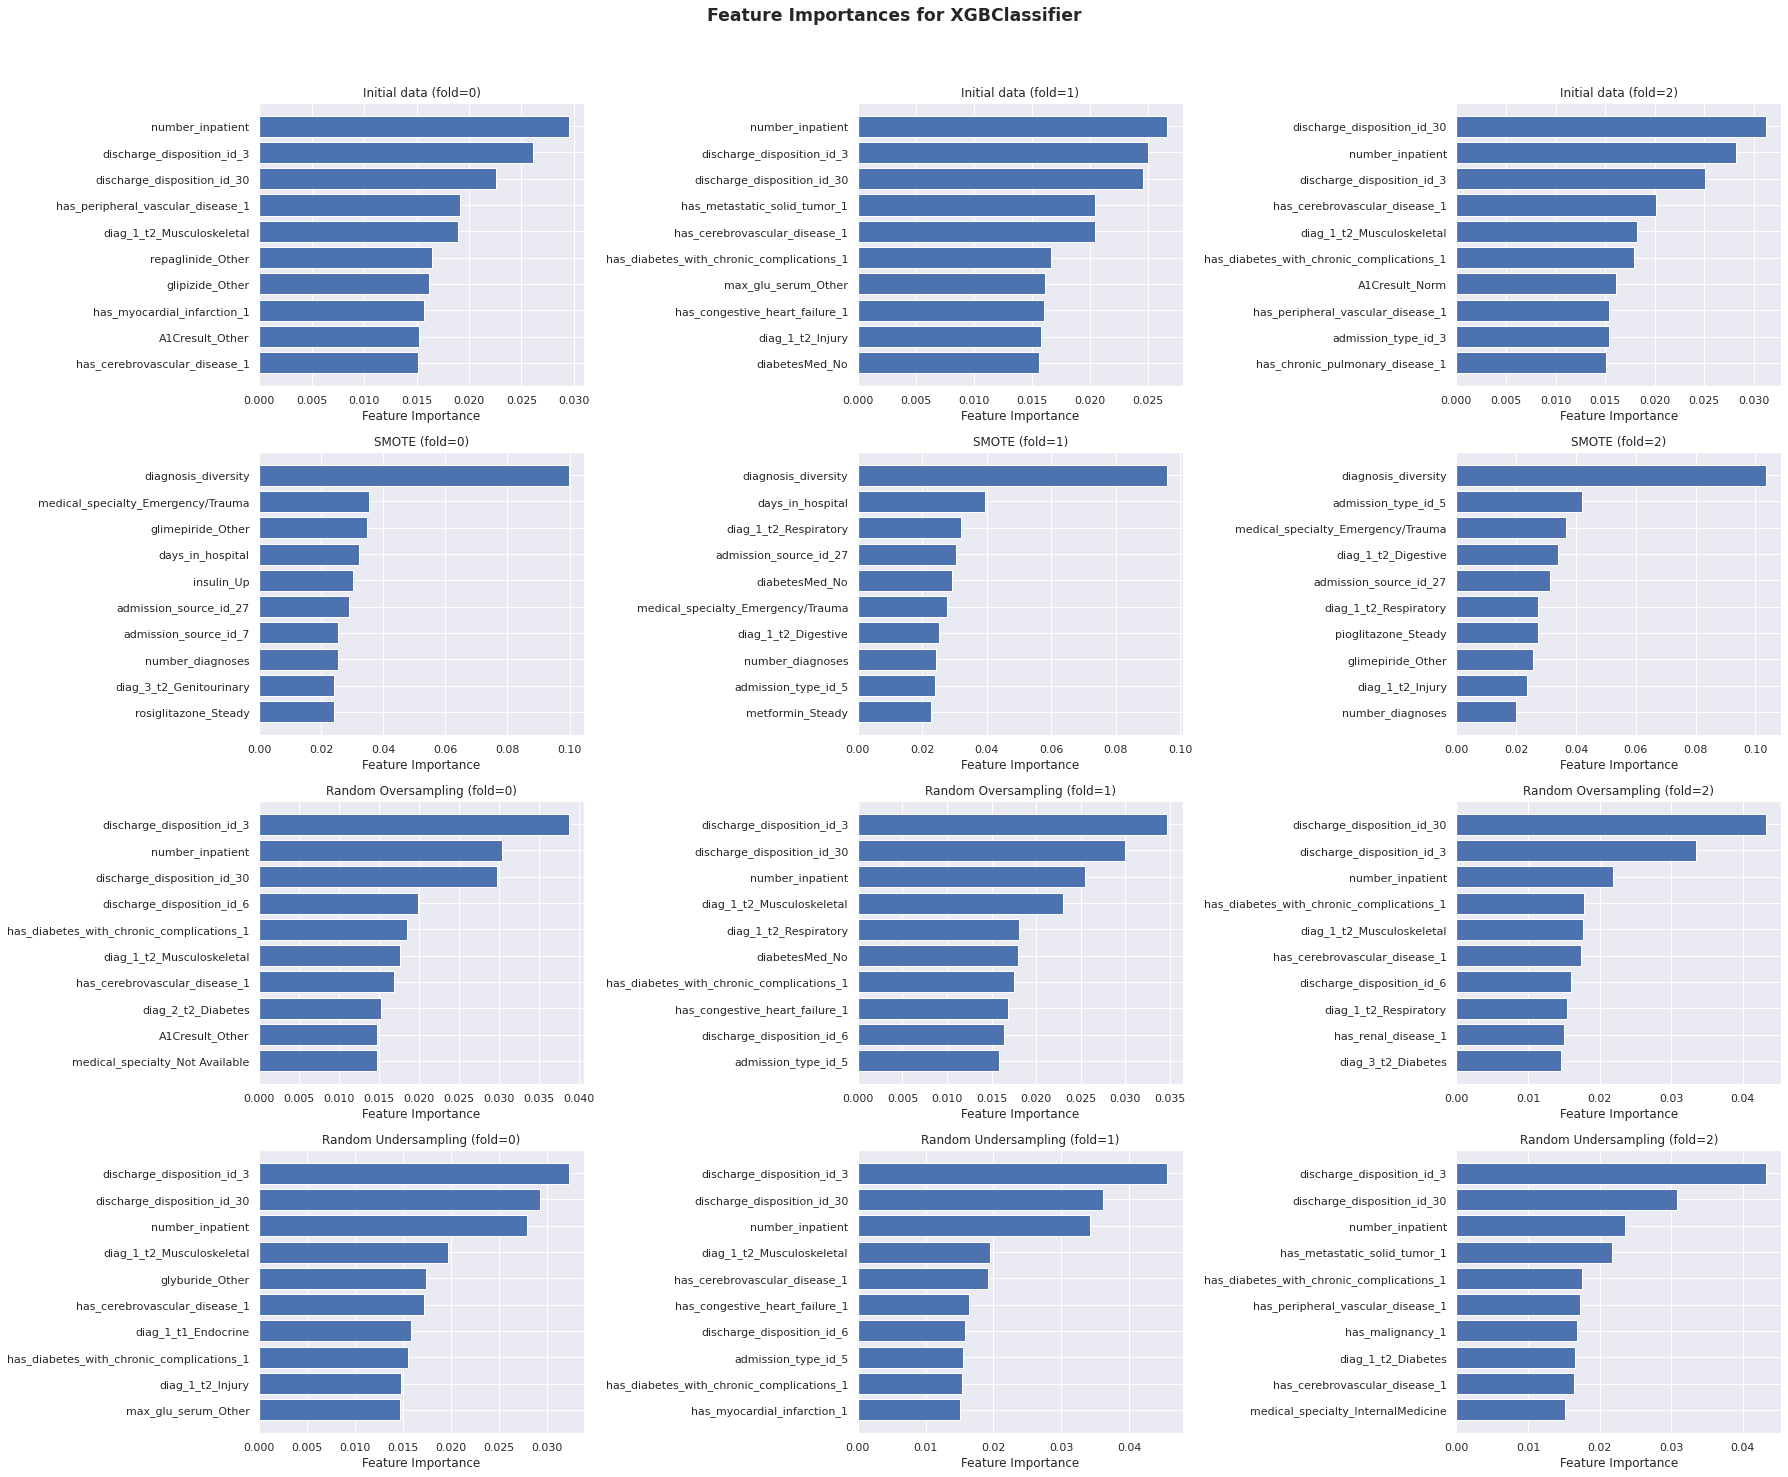

In [45]:
plot_model_feature_importance(xgb_models)

In [46]:
del xgb_models; del xgb;

# 6. Conclusion

In this notebook, we defined a suite of metrics that would be most useful in evaluating models with respect to our data. Our data is imbalanced, where early readmission patients only account for about 9% of our dataset. We decided to evaluate models with precision, recall, f2-score, and ROC AUC. We prioritize the recall score and weighted metrics like the f2-score, as we would like to minimize false negatives.

Class imbalance risks biasing our models by exposing them to a disproportionate number of observations per class. We explored sampling methods to counteract this. We experimented with SMOTE (Synthetic Minority Oversampling Technique), random oversampling the minority class, and random undersampling the majority class. We then performed 3-fold cross-validation on each of these generated datasets to determine which method yielded the best overall performance and to also get a general idea of which types of models are most effective in learning from our data. Random undersampling yielded higher recall values on average, without sacrificing precision or ROC AUC. SMOTE performed the worst on average among all non-dummy models.

We evaluated both a dummy classifier that predicted the most frequent class in our training data and a LACE index classifier, which predicts early readmission based on well-known features like the number of emergency visits the patient had in the past year or the kinds of comorbidities they have. The LACE index performed only marginally better than the dummy classifier, generating poor precision and recall scores and an ROC AUC score that was barely better than random. This indicates that the current heuristic for identifying early readmission is lacking and that there is room for improvement. 

Logistic regression and tree-based ensemble methods tend to perform better on average. We will consider random forest or LGBM classifiers to optimize given their effectiveness and their reasonable training speed.
 
We plotted feature importances for each model, sampling method, fold combination. The number of in-patient visits, number of medications, number of lab procedures, days in the hospital, and transferring to a skilled nursing facility or an undefined health institution appear to be important features.

With this in mind, we will try to improve our model through hyperparameter optimization in our next notebook.